In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

## 0.Load Data

In [116]:
# load EMG data
EMG_file_name='s2/S2_A1_E1.mat'
emg_data = loadmat(EMG_file_name)

print(f"What kind of data structure are we working with? {type(emg_data)}")
print(f"What are the keys of the data structure? {[key for key in emg_data.keys()]}")

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? ['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']


In [117]:
emg= emg_data["emg"].copy()
stimulus = emg_data["restimulus"] 
repetition = emg_data["rerepetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


## 1. Preprocessing

### 1.1 Apply bandpass filter
Before preprocessing, we visualize the rawdata for subject2.

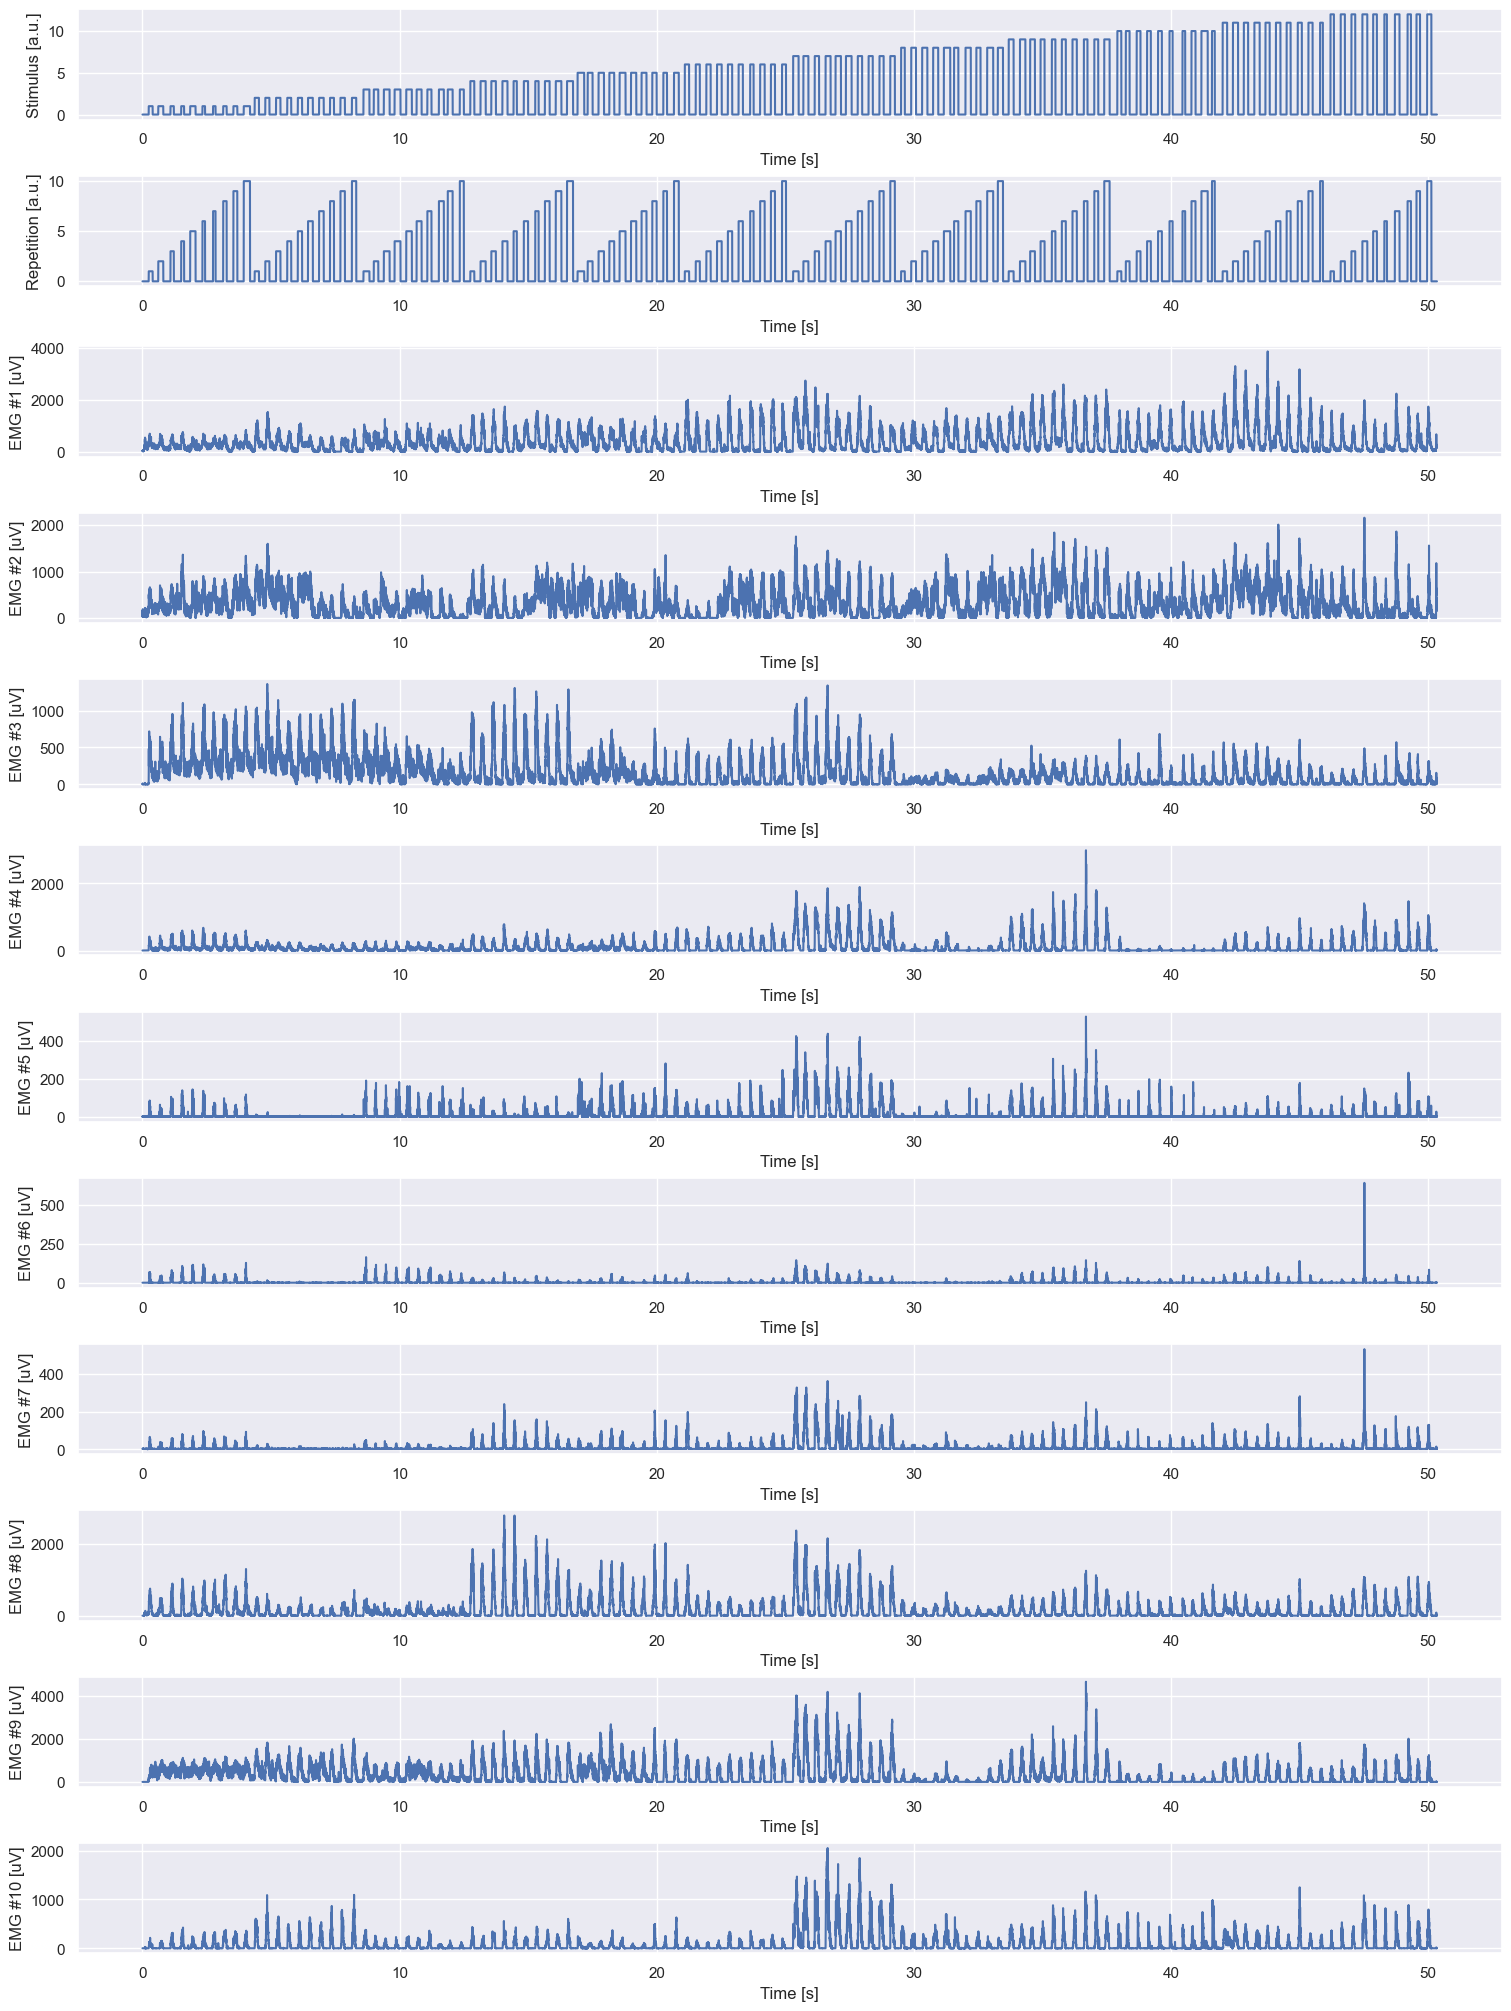

In [118]:
n_channels = emg.shape[1]

fs = 2000 # According to the references, sampling frequency here is 2000 Hz.

time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)

fig, ax = plt.subplots(n_channels+2, 1, constrained_layout=True, figsize=(15, 20))

ax[0].plot(time_steps, stimulus)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Stimulus [a.u.]")

ax[1].plot(time_steps, repetition)
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Repetition [a.u.]")

for channel_idx in range(n_channels):
    ax[channel_idx+2].plot(time_steps, emg[:, channel_idx]*1000)
    ax[channel_idx+2].set_xlabel("Time [s]")
    ax[channel_idx+2].set_ylabel(f"EMG #{channel_idx+1} [uV]")

Because the sEMG data was gathered using OttoBock MyoBock 13E200 surface EMG electrodes3, it is supposed to be amplified, bandpass-filtered and rectified version of the raw sEMG signal.

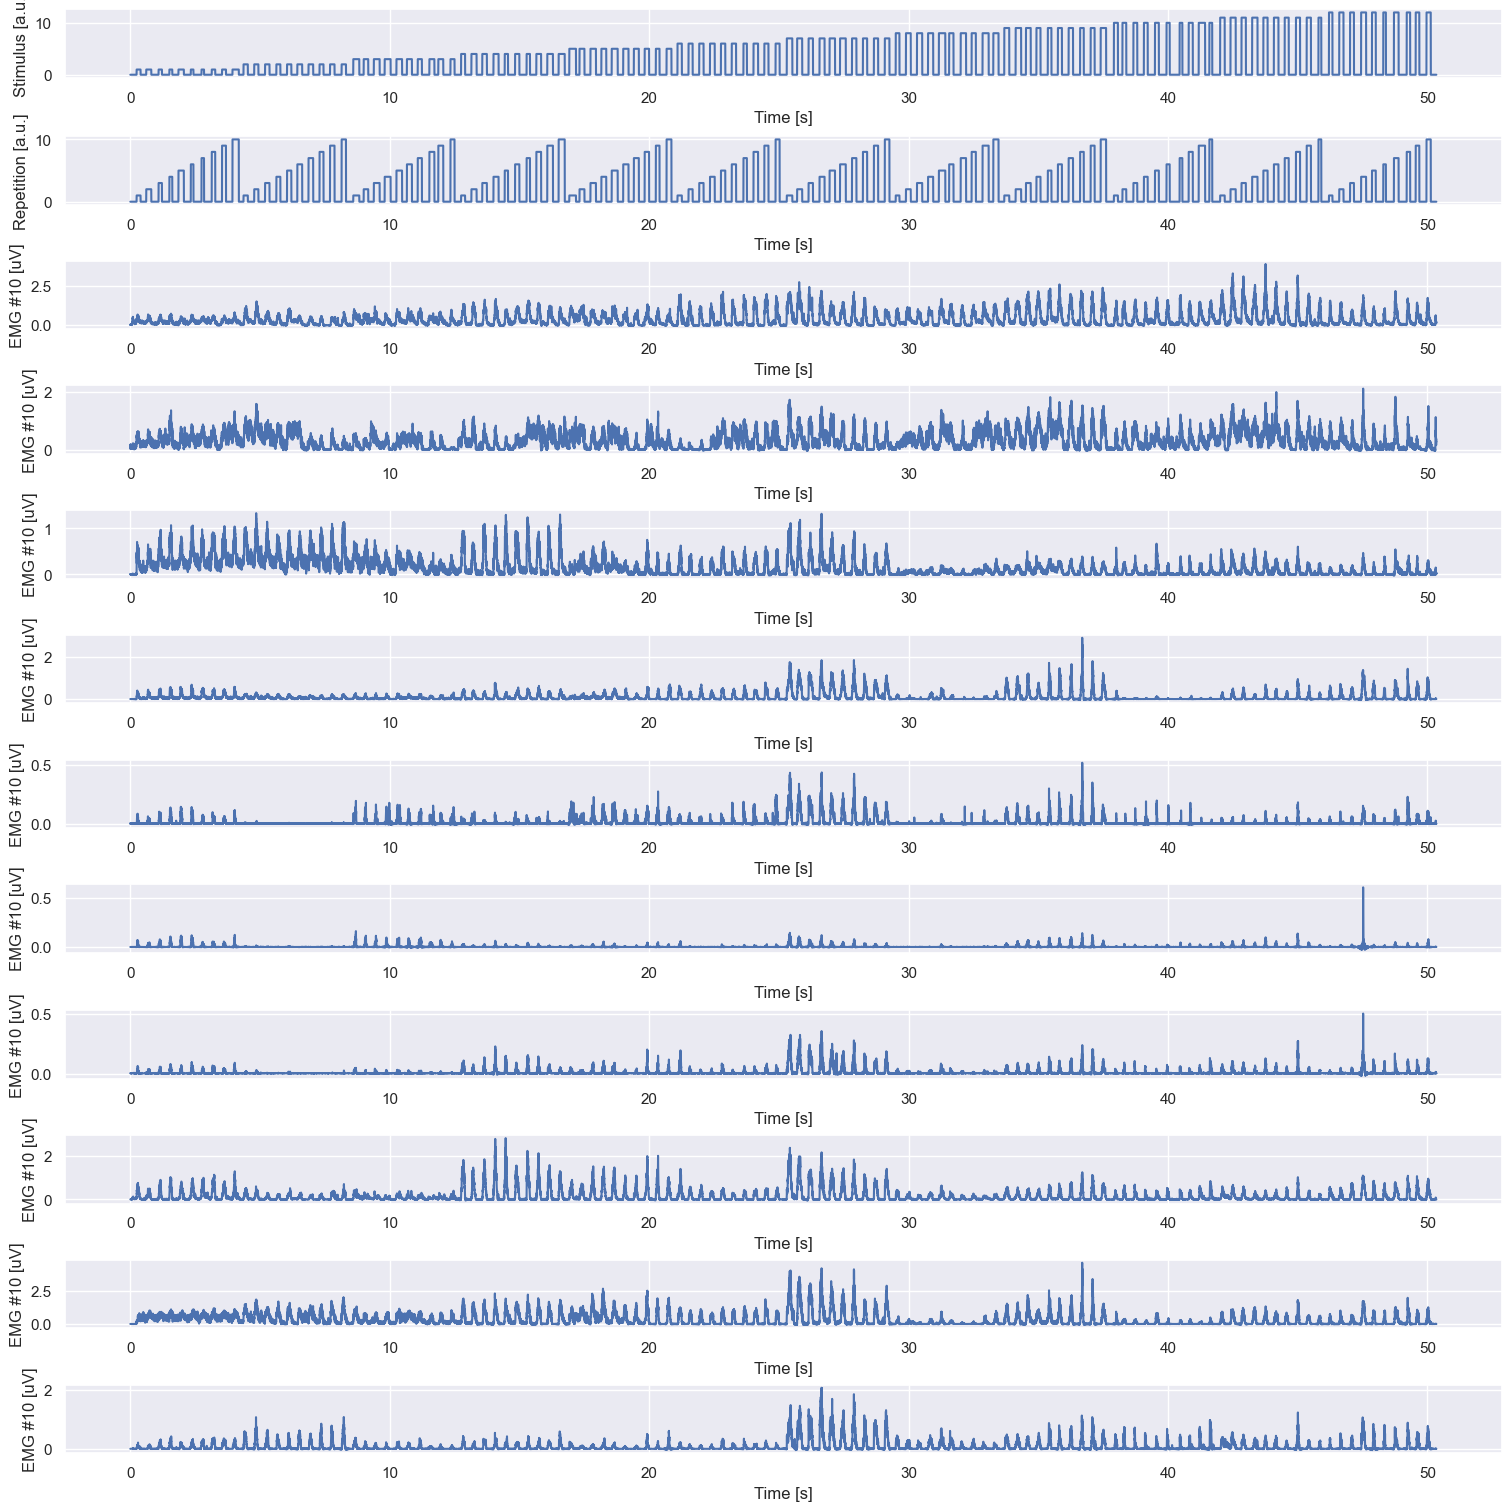

In [119]:
bandpass_cutoff_frequencies_Hz = (15, 500) 
sos = butter(N=0, Wn=bandpass_cutoff_frequencies_Hz, fs=fs, btype="bandpass", output="sos") 
emg_filtered = sosfiltfilt(sos, emg.T).T 


powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)] # removing 50Hz noise and its harmonics

for noise_frequency in powergrid_noise_frequencies_Hz:
    sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
    emg_filtered = sosfiltfilt(sos, emg_filtered.T).T

fig, ax = plt.subplots(n_channels+2, 1, constrained_layout=True, figsize=(15, 15))
ax[0].plot(time_steps, stimulus)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Stimulus [a.u.]")

ax[1].plot(time_steps, repetition)
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Repetition [a.u.]")
for i in range(n_channels):
    ax[i+2].plot(time_steps, emg_filtered[:, i])
    ax[i+2].set_xlabel("Time [s]")
    ax[i+2].set_ylabel(f"EMG #{channel_idx+1} [uV]")

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

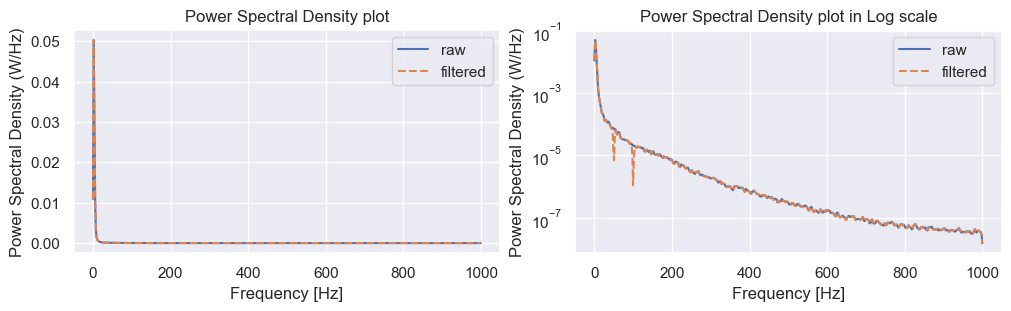

In [120]:
freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0],fs = fs,  nperseg=1064)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

### 1.2 Rectify signals

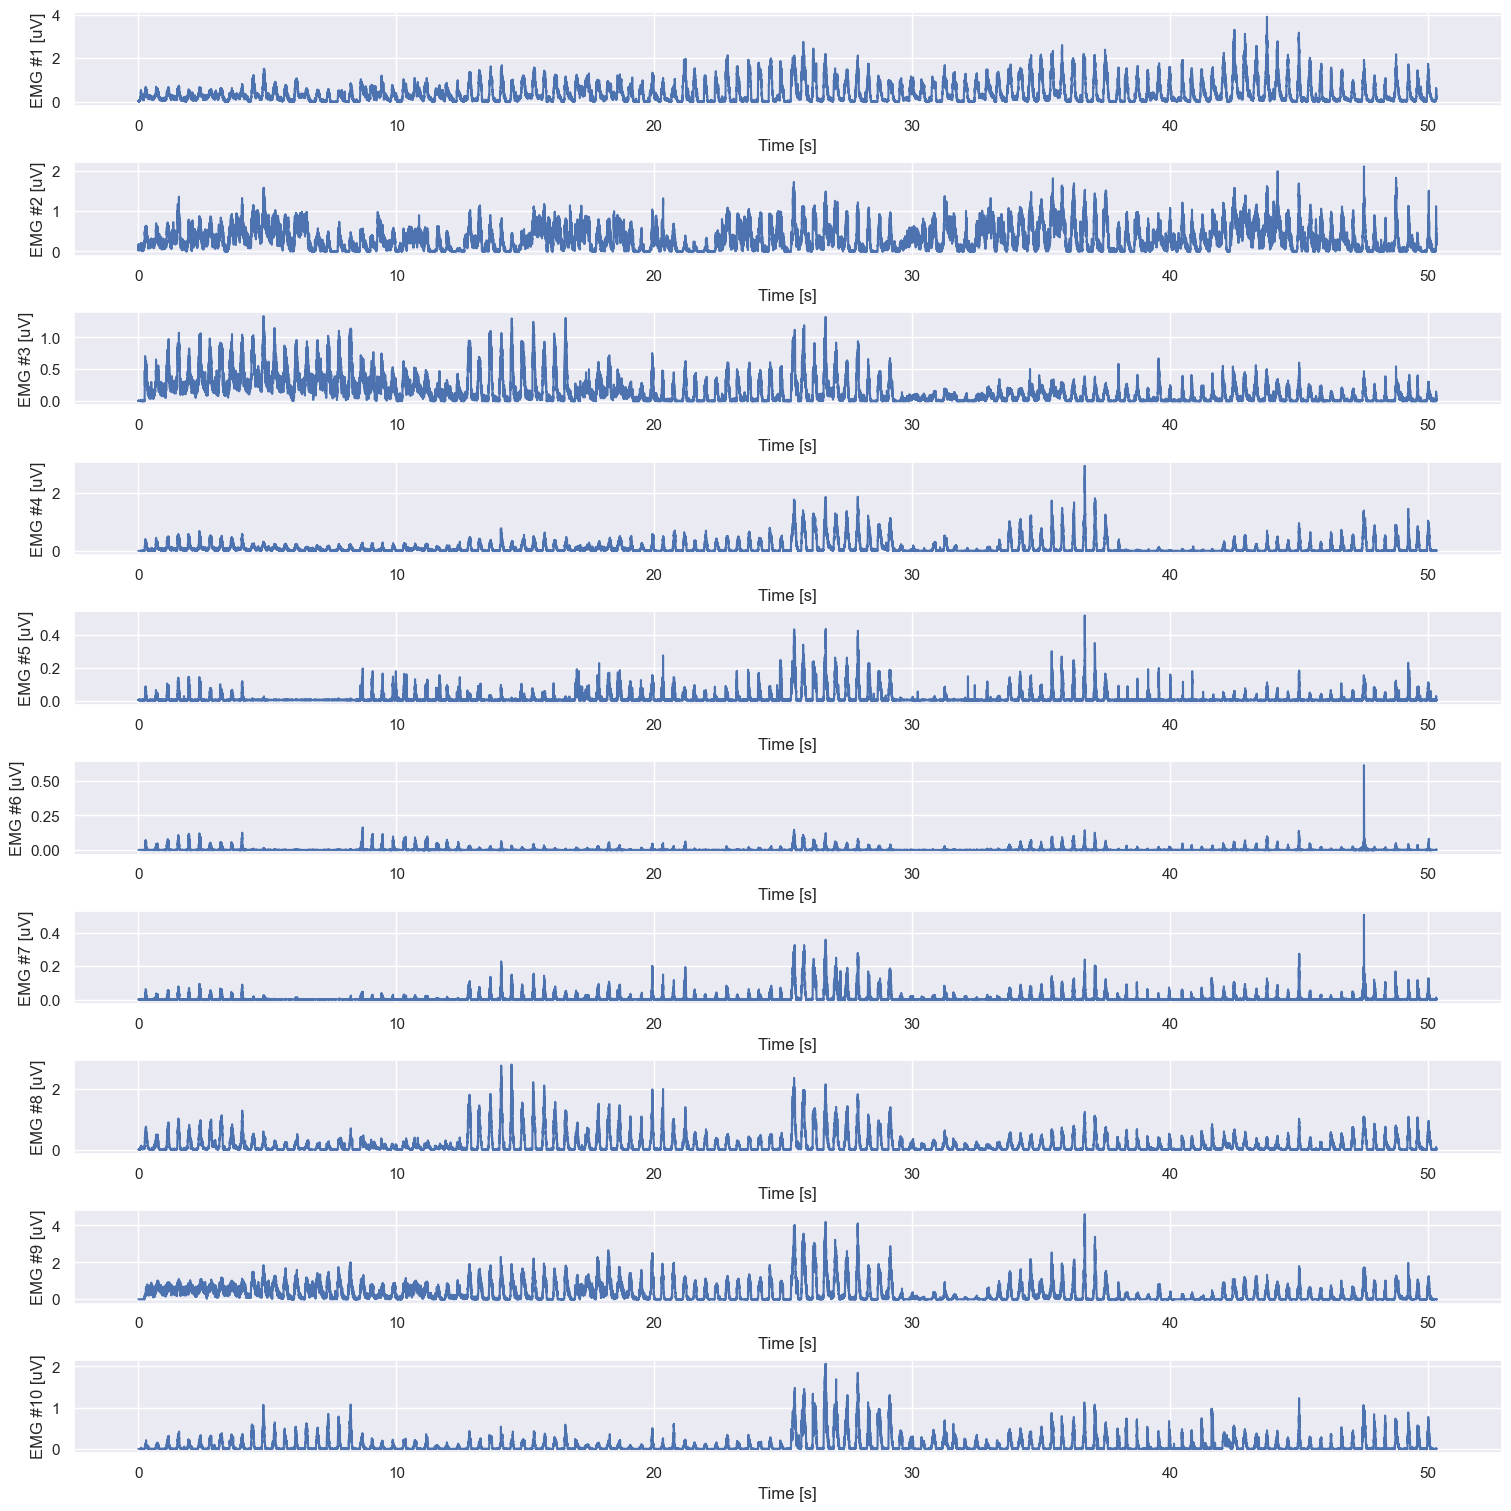

In [121]:
emg_rectified = np.abs(emg_filtered)

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_rectified[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f"EMG #{channel_idx+1} [uV]")

In [122]:
# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 12
How many repetitions are there? 10


In [123]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

### 1.3 Compute the envelop of the signal

In [124]:
mov_mean_size = 200
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 

Text(0.5, 0.98, 'Envelopes of the EMG signal')

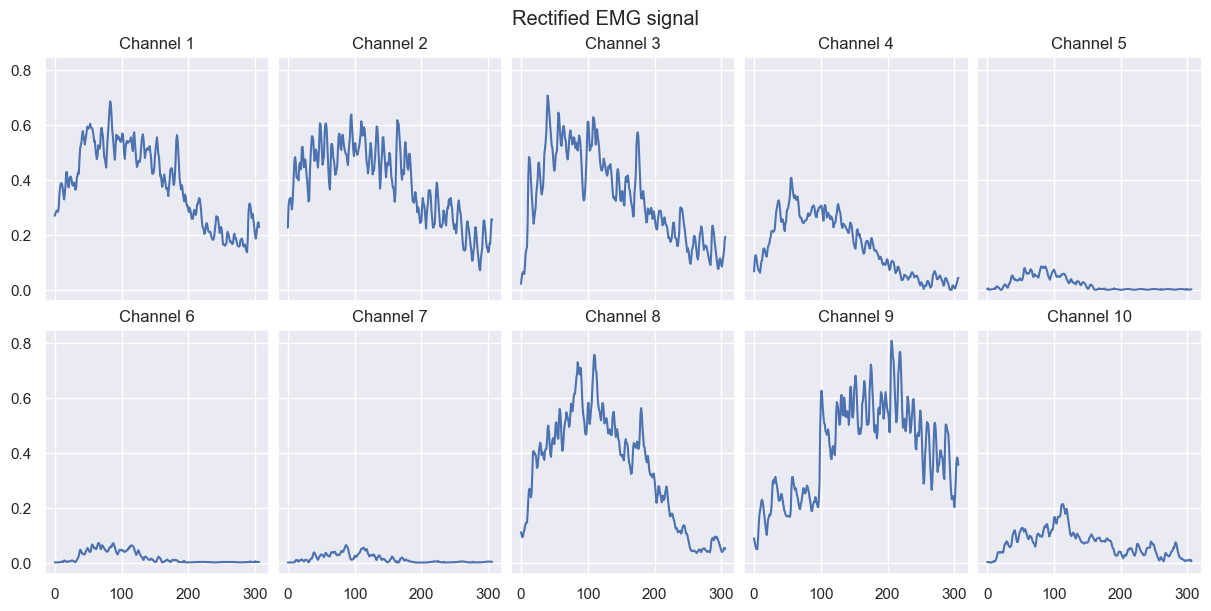

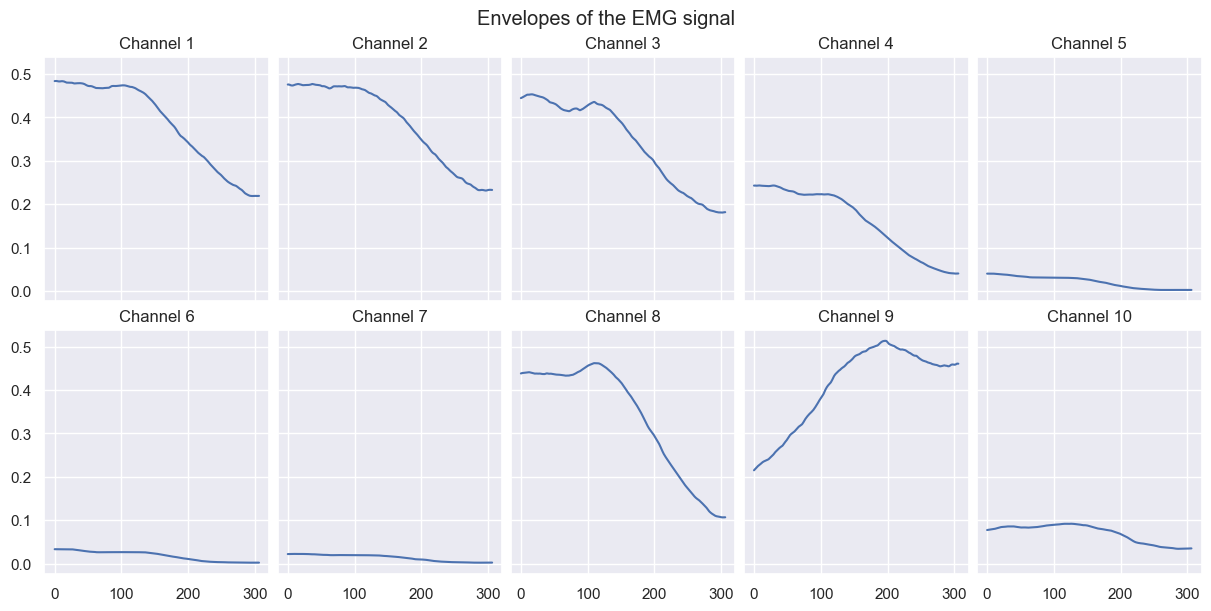

In [125]:
# Plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

### 1.4 Visualizing across repetitions

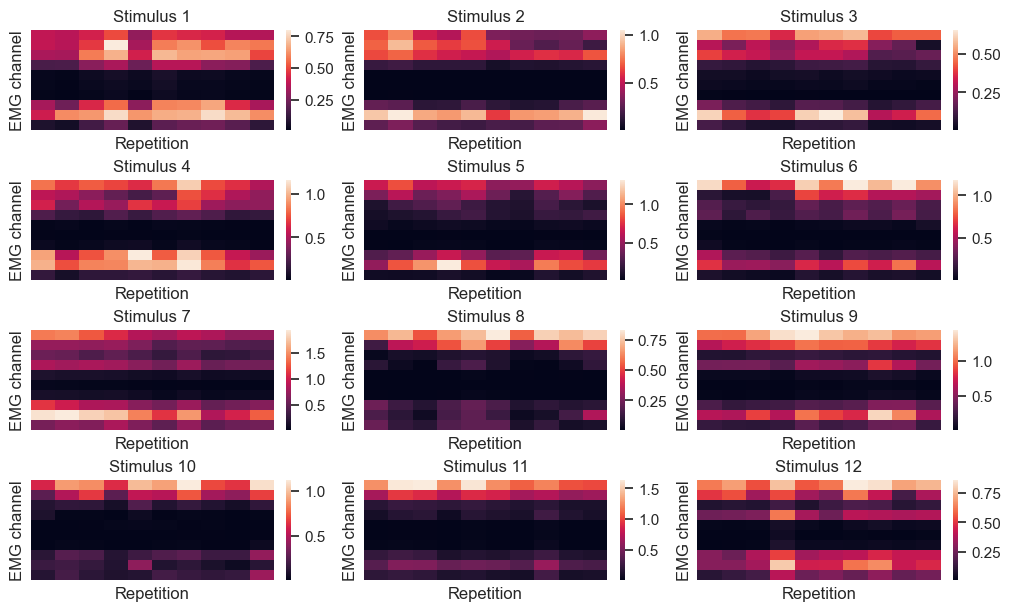

In [126]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

## 2. Split data

In [127]:
reps = np.arange(n_repetitions)
np.random.shuffle(reps)

train_reps = reps[:7]  # First 7 repetitions for training
val_reps = reps[7:9]   # Next 2 repetitions for validation
test_reps = reps[9:]


In [128]:

train_emg = {
    'emg' : emg_rectified[np.isin(repetition.flatten(), train_reps),:],
    'envelopes' :[emg_envelopes[i] for i in train_reps][0],
    'windows' : [emg_envelopes[i] for i in train_reps][0],
    'restimulus' : stimulus[np.isin(repetition.flatten(), train_reps),:],
    'rerepitions' : repetition[np.isin(repetition.flatten(), train_reps),:]
}

val_emg = {
    'emg' : emg_rectified[np.isin(repetition.flatten(), val_reps),:],
    'envelopes' :[emg_envelopes[i] for i in val_reps][0],
    'windows' : [emg_envelopes[i] for i in val_reps][0],
    'restimulus' : stimulus[np.isin(repetition.flatten(), val_reps),:],
    'rerepitions' : repetition[np.isin(repetition.flatten(), val_reps),:]
}

test_emg = {
    'emg' : emg_rectified[np.isin(repetition.flatten(), test_reps),:],
    'envelopes' :[emg_envelopes[i] for i in test_reps][0],
    'windows' : [emg_envelopes[i] for i in test_reps][0],
    'restimulus' : stimulus[np.isin(repetition.flatten(), test_reps),:],
    'rerepitions' : repetition[np.isin(repetition.flatten(), test_reps),:]
}

## 3. Extract features from the trials (at least 5 different ones). 

In [129]:
#before
mean_std_norm = lambda x: (x - x.mean()) / x.std()
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None, feature_norm=False):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                cur_feature = feature(emg[selected_tsteps, :])
                if feature_norm:
                    cur_feature = mean_std_norm(cur_feature)
                dataset[current_sample_index, selected_features] = cur_feature
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

加了psd但是还没加包络相关的

c:\Users\THUNDEROBOT\.conda\envs\NSSP\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 226, using nperseg = 226
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\THUNDEROBOT\.conda\envs\NSSP\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 204, using nperseg = 204
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\THUNDEROBOT\.conda\envs\NSSP\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 196, using nperseg = 196
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\THUNDEROBOT\.conda\envs\NSSP\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 255, using nperseg = 255
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\THUNDER

dataset dimension: (120, 70)
labels dimension: (120,)


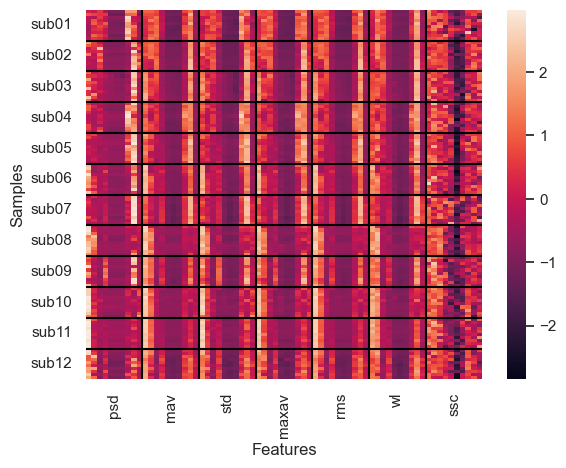

In [130]:
# Define the features 

# Power Spectral Density (PSD)
from scipy.signal import welch
psd = lambda x: np.sum(welch(x, axis=0)[1], axis=0)
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)

dataset, labels = build_dataset_from_ninapro(
    emg=emg_filtered,
    stimulus=stimulus,
    repetition=repetition,
    features=[psd, mav, std, maxav, rms, wl, ssc],
    feature_norm=True
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")
sns.heatmap(dataset)
plt.xlabel('Features')
plt.ylabel('Samples')
plt.yticks(range(5, 116, 10), [f'sub%02d' % (x+1) for x in range(12)])
plt.xticks(range(5, 66, 10), ['psd', 'mav', 'std', 'maxav', 'rms', 'wl', 'ssc'])


# get the current axis
ax = plt.gca()

# add vertical lines
for x in range(10, dataset.shape[1], 10):  # every 10 features
    ax.axvline(x=x, color='black', linestyle='-', linewidth=1.5) 

# add horizontal lines
for y in range(10, dataset.shape[0], 10):  # every 10 samples
    ax.axhline(y=y, color='black', linestyle='-', linewidth=1.5)


## 4. Perform classification on the data of subject 2 - Gradient Boost Decision Tree

n_training: 84, n_validation: 18, n_test: 18
Accuracy score: 0.7777777777777778


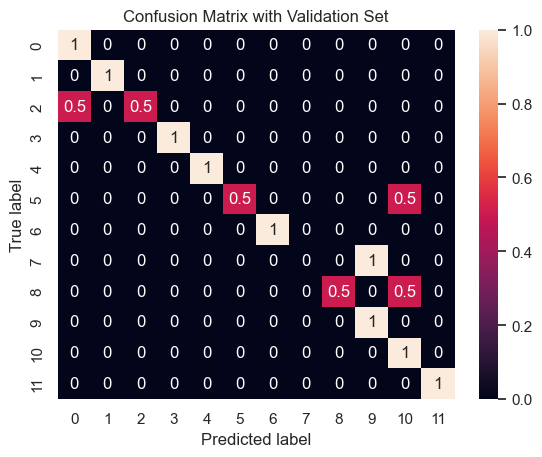

In [137]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

#Train:Validation:Test=70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(dataset, labels, test_size=0.3, random_state=42,stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f'n_training: {X_train.shape[0]}, n_validation: {X_val.shape[0]}, n_test: {X_test.shape[0]}')

# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z = scaler.transform(X_val)

# Classifier
clf = GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.1, min_samples_leaf=4,min_samples_split=2,random_state=42)
clf.fit(X_train_z, y_train)

# Predict in validation
y_pred = clf.predict(X_val_z)

# Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy score: {accuracy}")

# Confusion Matrix
confmat = confusion_matrix(y_val, y_pred, normalize="true")
fig, ax = plt.subplots()

sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix with Validation Set")
plt.show()

Accuracy score: 0.8333333333333334


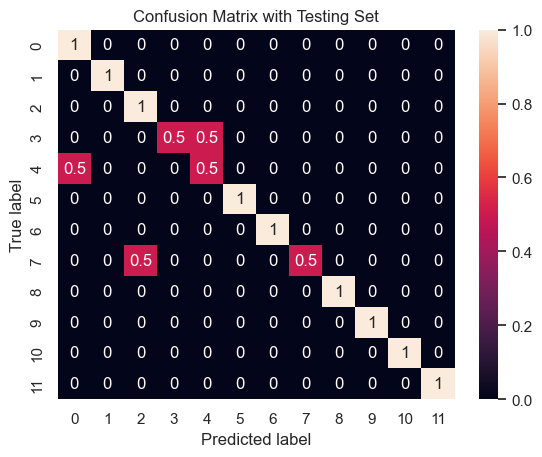

In [138]:
X_test_z = scaler.transform(X_test)
# Predict in test
y_pred = clf.predict(X_test_z)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Confusion Matrix
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()

sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix with Testing Set")
plt.show()

In [139]:
# perform cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train_z, y_train, cv=5)
print(f"Accuracy scores of all models: {scores}")
print(f"Mean accuracy across all models: {np.mean(scores)}")

Accuracy scores of all models: [0.70588235 0.76470588 0.76470588 1.         0.5625    ]
Mean accuracy across all models: 0.7595588235294117


## 1.5

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\THUNDEROBOT\.conda\envs\NSSP\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
Best Accuracy: 0.7845588235294116
Test Accuracy after Optimization: 0.8333333333333334


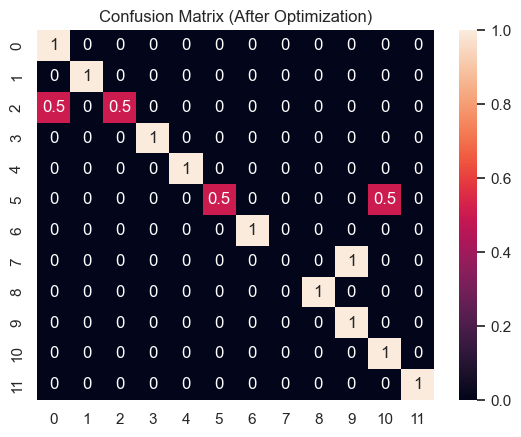

In [166]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter search space
param_grid = {
    "n_estimators": [100,200,300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4],
}

# Instantiation model
clf = GradientBoostingClassifier(random_state=42)

# grid search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_z, y_train)

# Output optimum parameter
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate the validation set with the best parameters
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_val_z)

# Recalculate the accuracy and confusion matrix
accuracy = accuracy_score(y_val, y_pred)
print(f"Test Accuracy after Optimization: {accuracy}")

confmat = confusion_matrix(y_val, y_pred, normalize="true")
sns.heatmap(confmat, annot=True)
plt.title("Confusion Matrix (After Optimization)")
plt.show()

Test Accuracy after Optimization:0 0.8333333333333334


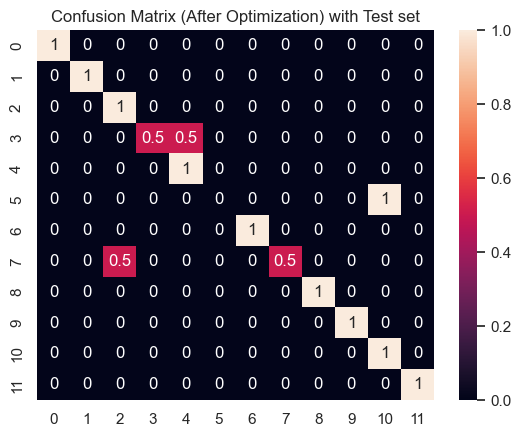

In [167]:
# Evaluate the test set with the best parameters
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_z)

# Recalculate the accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy after Optimization:0 {accuracy}")

confmat = confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(confmat, annot=True)
plt.title("Confusion Matrix (After Optimization) with Test set")
plt.show()

## 1.6.1 Feature Selection 

In [177]:
feature_names = ['psd', 'mav', 'std', 'maxav', 'rms', 'wl', 'ssc'] * (dataset.shape[1] // 7)  
sorted_indices = np.argsort(feature_importances)[::-1]  # sort the indices in descending order

# output the feature ranking
print(dataset.shape[0])
print(dataset.shape[1])
print("Feature ranking:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")

# choose the top k features
k = 5 # set the number of features to keep
top_k_features = sorted_indices[:k]
X_train_selected = X_train[:, top_k_features]
X_val_selected = X_val[:, top_k_features]

# retrain the model
clf_selected = GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=42)
clf_selected.fit(X_train_selected, y_train)
y_pred_selected = clf_selected.predict(X_val_selected)

# evaluate the model
accuracy_selected = accuracy_score(y_val, y_pred_selected)
print(f"Accuracy after feature selection (top {k} features): {accuracy_selected}")

120
70
Feature ranking:
maxav: 0.0815
rms: 0.0804
std: 0.0804
ssc: 0.0787
wl: 0.0603
mav: 0.0509
mav: 0.0479
maxav: 0.0444
std: 0.0444
std: 0.0395
mav: 0.0358
ssc: 0.0303
rms: 0.0292
std: 0.0291
rms: 0.0287
psd: 0.0184
wl: 0.0175
wl: 0.0150
psd: 0.0134
psd: 0.0134
ssc: 0.0116
rms: 0.0109
maxav: 0.0096
ssc: 0.0086
mav: 0.0085
ssc: 0.0082
mav: 0.0080
psd: 0.0063
rms: 0.0061
mav: 0.0060
mav: 0.0059
maxav: 0.0056
wl: 0.0053
mav: 0.0053
mav: 0.0050
maxav: 0.0046
rms: 0.0040
std: 0.0040
psd: 0.0038
wl: 0.0036
std: 0.0035
maxav: 0.0032
ssc: 0.0025
rms: 0.0021
maxav: 0.0020
wl: 0.0019
std: 0.0018
psd: 0.0018
maxav: 0.0017
ssc: 0.0012
psd: 0.0012
wl: 0.0011
wl: 0.0009
rms: 0.0008
mav: 0.0008
wl: 0.0008
ssc: 0.0007
rms: 0.0004
ssc: 0.0002
std: 0.0002
psd: 0.0002
wl: 0.0001
maxav: 0.0001
ssc: 0.0001
psd: 0.0001
std: 0.0001
maxav: 0.0000
std: 0.0000
rms: 0.0000
psd: 0.0000
Accuracy after feature selection (top 5 features): 0.8333333333333334


## 1.6.2 Dimension Reduction 

In [178]:
from sklearn.decomposition import PCA

# Use PCA to reduce the number of features
n_components = 15  # 
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_z)
X_val_pca = pca.transform(X_val_z)

# retrain the model
clf_pca = GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=42)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_val_pca)

# evaluate the performance
accuracy_pca = accuracy_score(y_val, y_pred_pca)
print(f"Validation Accuracy after PCA with {n_components} components: {accuracy_pca}")



Validation Accuracy after PCA with 15 components: 0.7222222222222222


Best number of PCA components: 20
Best Validation Accuracy: 0.7778


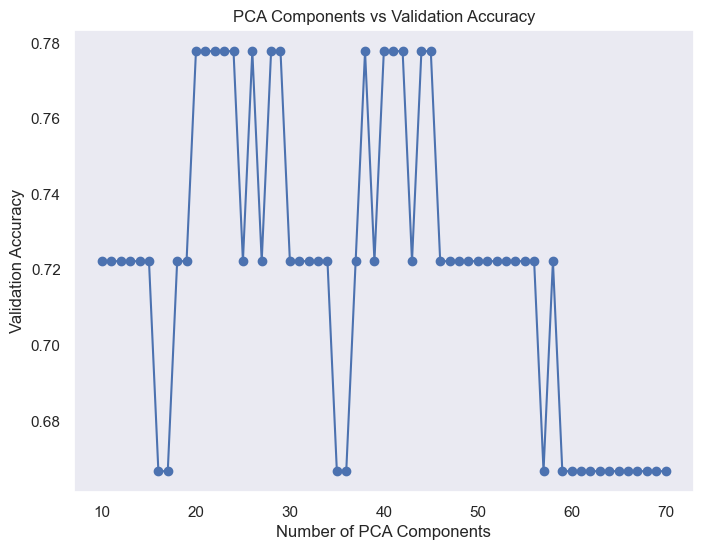

In [179]:
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# automatically find the best number of PCA components
n_features = X_train_z.shape[1]  # total number of features
best_accuracy = 0
best_n_components = 0
accuracies = []

# test different number of components
for n_components in range(10, n_features+1):  # components from 10 to n_features (inclusive)
    pca = PCA(n_components=n_components)
    
    # Use PCA to reduce the number of features
    X_train_pca = pca.fit_transform(X_train_z)
    X_val_pca = pca.transform(X_val_z)
    
    # train the model
    clf_pca = GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=42)
    clf_pca.fit(X_train_pca, y_train)
    
    # evaluate the performance
    y_pred_pca = clf_pca.predict(X_val_pca)
    accuracy_pca = accuracy_score(y_val, y_pred_pca)
    accuracies.append(accuracy_pca)
    
    # record the best number of components and accuracy
    if accuracy_pca > best_accuracy:
        best_accuracy = accuracy_pca
        best_n_components = n_components

# Best number of PCA components and accuracy
print(f"Best number of PCA components: {best_n_components}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Accuracy of visualization with different number of features

plt.figure(figsize=(8, 6))
plt.plot(range(10, n_features + 1), accuracies, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Validation Accuracy')
plt.title('PCA Components vs Validation Accuracy')
plt.grid()
plt.show()



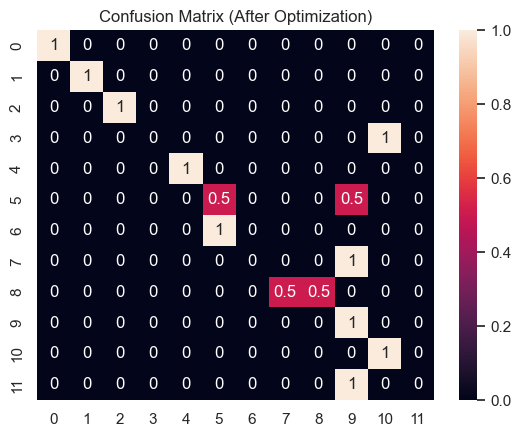

In [186]:
confmat = confusion_matrix(y_val, y_pred_pca, normalize="true")
sns.heatmap(confmat, annot=True)
plt.title("Confusion Matrix (After Optimization)")
plt.show()

Test Set Accuracy after PCA with 20 components: 0.4444444444444444


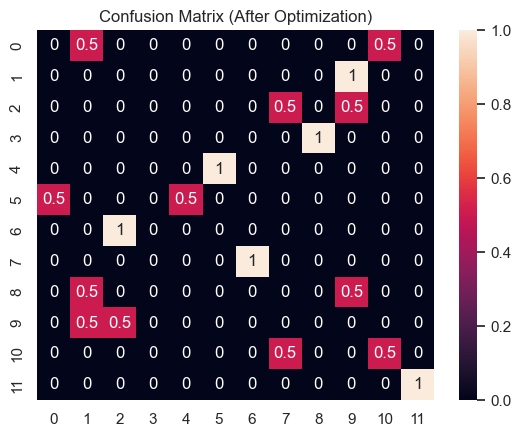

In [185]:
# Evaluate the test set with the best number of PCA components
n_components =20  # best number of PCA components

# Use PCA to reduce the number of features
X_train_pca = pca.fit_transform(X_train_z)

# test set
X_test_pca = pca.transform(X_test_z)

# retrain the model
clf_pca = GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=42)
clf_pca.fit(X_train_pca, y_train)

# predict the test set
y_pred_test_pca = clf_pca.predict(X_test_pca)

# evaluate the performance
accuracy_test_pca = accuracy_score(y_test, y_pred_test_pca)
print(f"Test Set Accuracy after PCA with {n_components} components: {accuracy_test_pca}")

confmat = confusion_matrix(y_val, y_pred_test_pca, normalize="true")
sns.heatmap(confmat, annot=True)
plt.title("Confusion Matrix (After Optimization)")
plt.show()

In [184]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Use LDA to reduce the number of features
n_components = min(len(np.unique(y_train)) - 1, X_train_z.shape[1])  # LDAs can only reduce to n_classes - 1
lda = LDA(n_components=n_components)
X_train_lda = lda.fit_transform(X_train_z, y_train)
X_val_lda = lda.transform(X_val_z)

# retrain the model
clf_lda = GradientBoostingClassifier(n_estimators=300, max_depth=3, random_state=42)
clf_lda.fit(X_train_lda, y_train)
y_pred_lda = clf_lda.predict(X_val_lda)


accuracy_lda = accuracy_score(y_val, y_pred_lda)
print(f"Accuracy after LDA with {n_components} components: {accuracy_lda}")

Accuracy after LDA with 11 components: 0.6111111111111112


## 2. Generalization Across Subjects

### 2.1. Load EMG data of all 27 subjects

In [ ]:
emg_all = np.zeros((0, 10))
stimulus_all = np.zeros((0, 1))
repetition_all = np.zeros((0, 1))

for sub_idx in range(1, 27+1):

    # 1. Load data

    print('---- Loading Data From {sub_idx}')
    EMG_file_name = f's{sub_idx}/S{sub_idx}_A1_E1.mat'
    emg_data = loadmat(EMG_file_name)
    emg = emg_data["emg"].copy()
    stimulus = emg_data["restimulus"]
    repetition = emg_data["rerepetition"]
    print(f'    EMG: {emg.shape}, Stimulus {stimulus.shape}, Repetition {repetition.shape}')

    # 2. Perform bandpass filtering

    n_channels = emg.shape[1]
    fs = 2000
    time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)
    bandpass_cutoff_frequencies_Hz = (15, 500)
    sos = butter(N=0, Wn=bandpass_cutoff_frequencies_Hz, fs=fs, btype="bandpass", output="sos")
    emg_filtered = sosfiltfilt(sos, emg.T).T
    powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)] # removing 50Hz noise and its harmonics
    for noise_frequency in powergrid_noise_frequencies_Hz:
        sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
        emg_filtered = sosfiltfilt(sos, emg_filtered.T).T

    # 3. Rectify
    emg_rectified = np.abs(emg_filtered)
    n_stimuli = len(np.unique(stimulus)) - 1
    n_repetitions = len(np.unique(repetition)) - 1
    n_channels = emg_rectified.shape[1]
    print(f'    n_stimuli: {n_stimuli}, n_repetitions: {n_repetitions}, n_channels: {n_channels}\n')

    # 4. Moving average
    mov_mean_size = 200
    mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size

    #initializing the data structure
    emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
    emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
            emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
            emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

    emg_all = np.vstack((emg_all, emg))
    stimulus_all = np.vstack((stimulus_all, stimulus))
    repetition_all = np.vstack((repetition_all, repetition))

In [161]:
dataset, labels = build_dataset_from_ninapro(
    emg=emg_all,
    stimulus=stimulus_all,
    repetition=repetition_all,
    features=[mav, std, maxav, rms, wl, ssc],
    feature_norm=True
)